In [1]:
import torch

import dataset_utils as dataset

import torch as t

from ML_cup.pytorch import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    torch.set_default_device(torch.device("cuda"))

GPU is available


In [3]:
import pandas as pd

#column_names = ['ID', 
#                'INPUT_1', 'INPUT_2', 'INPUT_3', 'INPUT_4', 'INPUT_5', 'INPUT_6', 'INPUT_7', 'INPUT_8', 'INPUT_9', 'INPUT_10','INPUT_11','INPUT_12',
#                'TARGET_x', 'TARGET_y', 'TARGET_z']
#dataframe = pd.read_csv("../data/ML-CUP24-TR.csv", sep=',', comment='#', names=column_names, index_col= 'ID')
#dataframe.head()

In [4]:

dev_data = dataset.load_dataset("../data/ML-CUP24-TR.csv")
blind_data = dataset.load_dataset("../data/ML-CUP24-TS.csv")

In [5]:
import time
# arrange the dataset into inputs and labels
from dataset_utils import arrange_datasets, train_val_kfold

# get a seed for the random state based on the current time
rand = int(time.time())
print(f"Random seed: {rand}")
torch.manual_seed(rand)
np.random.seed(rand)
X_dev, y_dev, X_blind = arrange_datasets(dev_data, blind_data)
train_folds, val_folds = train_val_kfold(X_dev, y_dev, folds=5, random_state=rand)

Random seed: 1739206278


In [6]:
# Split the dev data into train and validation with k-fold cross validation and minibatch
train_loaders, val_loaders, test_loader = dataset.torch_k_fold(dataset=dev_data, folds=5, batch_size=50,
                                                               random_state=rand)

# Model Definitions

In [7]:
def MLP():
    return t.nn.Sequential(
        t.nn.Linear(12, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 3)
    )


def MLPv2():
    return t.nn.Sequential(
        t.nn.Linear(12, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 3)
    )


def MLPv3():
    return t.nn.Sequential(
        t.nn.Linear(12, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 3)
    )

# Grid search for the best parameters
Uses two slightly different lr schedulers

In [21]:
parameters = [
    {'optimizer': 'SGD', 'lr': [0.01, 0.0075, 0.005, 0.003, 0.001],
     'weight_decay': [0.0, 0.0001, 0.0005, 0.001, 0.002],
     'momentum': [0.9, 0.85, 0.75],
     'nesterov': [True, False]}
]
lr_scheduler_params = {'mode': 'min', 'factor': 0.75, 'patience': 5, 'cooldown': 3, 'min_lr': 1e-6}

In [22]:
# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLP, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, max_epochs=300,
                                  scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=True, stability_threshold=0.1, patience=20)

Avg Train Loss: 0.2823604680597782, Avg Val Loss: 0.3503538489341736, Avg Fluctuation: 0.04926460736438736
('SGD', {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False})
Avg Train Loss: 0.24356537610292434, Avg Val Loss: 0.3372023582458496, Avg Fluctuation: 0.11893261897547651
('SGD', {'lr': 0.01, 'weight_decay': 0.0005, 'momentum': 0.95, 'nesterov': True})
Avg Train Loss: 0.2655979938805103, Avg Val Loss: 0.33477592170238496, Avg Fluctuation: 0.01693971384205295
('SGD', {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True})
Avg Train Loss: 0.25348909571766853, Avg Val Loss: 0.32496400475502013, Avg Fluctuation: 0.16686408656708326
('SGD', {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.95, 'nesterov': True})
Avg Train Loss: 0.2616611495614052, Avg Val Loss: 0.33718926906585694, Avg Fluctuation: 0.32219513327711286
('SGD', {'lr': 0.01, 'weight_decay': 0.0001, 'momentum': 0.95, 'nesterov': False})
Avg Train Loss: 0.2613071955740452, Avg Val Loss: 0.3330871

{'lr': 0.001, 'weight_decay': 0.002, 'momentum': 0.95, 'nesterov': False, 'optimizer': 'SGD'}
Fold: 0
Train Epoch: 0 Loss: 55.045166015625 Val Loss: 59.3909912109375
Train Epoch: 1 Loss: 54.35431957244873 Val Loss: 58.30924606323242
Train Epoch: 2 Loss: 53.22807216644287 Val Loss: 56.74494934082031
Train Epoch: 3 Loss: 51.668701171875 Val Loss: 54.80536651611328
Train Epoch: 4 Loss: 49.86677169799805 Val Loss: 52.602272033691406
Train Epoch: 5 Loss: 47.82877063751221 Val Loss: 50.23966979980469
Train Epoch: 6 Loss: 45.463387966156006 Val Loss: 47.714500427246094
Train Epoch: 7 Loss: 43.17418575286865 Val Loss: 44.9964599609375
Train Epoch: 8 Loss: 40.58466053009033 Val Loss: 42.08863067626953
Train Epoch: 9 Loss: 38.03072261810303 Val Loss: 39.000396728515625
Train Epoch: 10 Loss: 35.10697078704834 Val Loss: 35.74576950073242
Train Epoch: 11 Loss: 32.238430976867676 Val Loss: 32.34951400756836
Train Epoch: 12 Loss: 29.128618240356445 Val Loss: 28.846923828125
Train Epoch: 13 Loss: 25.8

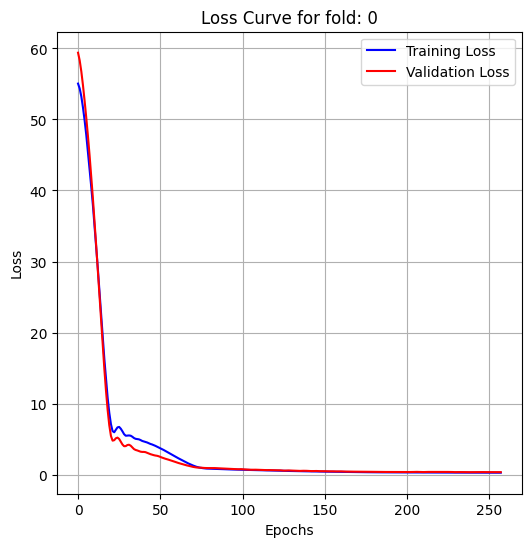

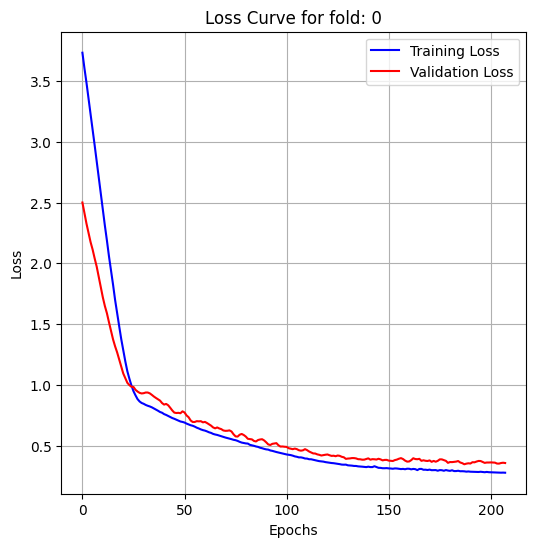

(0.2772335112094879, 0.3571062684059143, 0.003338810940660855)

In [26]:
# retrain the model with the best parameters
best_model = MLP()
print(best_pytorch_params)
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=50)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

lr_scheduler_params = {'mode': 'min', 'factor': 0.75, 'patience': 15, 'cooldown': 3, 'min_lr': 1e-6}
torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300, patience=20,
            verbose=True,
            #scheduler=lr_scheduler.OneCycleLR(optimizer, max_lr=best_pytorch_params['lr'], epochs=300,                          steps_per_epoch=len(train_loader)),
            scheduler=get_scheduler(optimizer, 'ReduceLROnPlateau', lr_scheduler_params),
            clip=0.8,
            skip_plot_points=50
            )


In [27]:
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(best_model, test_loader))

Evaluating the model on the test set
0.6974242925643921


In [28]:
lr_scheduler_params = {'mode': 'min', 'factor': 0.25, 'patience': 10, 'cooldown': 3, 'verbose': False, 'min_lr': 1e-6}

# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLP, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False)

C:\Users\alext\Desktop\Uni\ML\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Avg Train Loss: 0.3184023998677731, Avg Val Loss: 0.3794160008430481, Avg Fluctuation: 0.015279652339670675
('SGD', {'lr': 0.01, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': True})
Avg Train Loss: 0.38931436091661453, Avg Val Loss: 0.5068052172660827, Avg Fluctuation: 0.5579440907428578
('SGD', {'lr': 0.01, 'weight_decay': 0.0005, 'momentum': 0.95, 'nesterov': False})
Avg Train Loss: 0.3382266104221344, Avg Val Loss: 0.46923542618751524, Avg Fluctuation: 0.5486460453967218
('SGD', {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.95, 'nesterov': False})
Avg Train Loss: 0.3814382702112198, Avg Val Loss: 0.3914333701133728, Avg Fluctuation: 0.06801306996415879
('SGD', {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False})
Avg Train Loss: 0.3326585188508034, Avg Val Loss: 0.409797340631485, Avg Fluctuation: 0.0634157830704429
('SGD', {'lr': 0.01, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': False})
Avg Train Loss: 0.2738733313977718, Avg Val Loss: 0.3883794188

C:\Users\alext\Desktop\Uni\ML\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold: 0
Train Epoch: 0 Loss: 57.60776996612549 Val Loss: 63.32477951049805
Train Epoch: 1 Loss: 57.0207633972168 Val Loss: 62.28618621826172
Train Epoch: 2 Loss: 55.96763229370117 Val Loss: 60.79575729370117
Train Epoch: 3 Loss: 54.566226959228516 Val Loss: 58.97415542602539
Train Epoch: 4 Loss: 52.99278545379639 Val Loss: 56.89990997314453
Train Epoch: 5 Loss: 51.09690761566162 Val Loss: 54.615970611572266
Train Epoch: 6 Loss: 49.06290149688721 Val Loss: 52.14991760253906
Train Epoch: 7 Loss: 47.0092830657959 Val Loss: 49.53229904174805
Train Epoch: 8 Loss: 44.65596866607666 Val Loss: 46.76026153564453
Train Epoch: 9 Loss: 42.25298595428467 Val Loss: 43.858551025390625
Train Epoch: 10 Loss: 39.64111614227295 Val Loss: 40.78990936279297
Train Epoch: 11 Loss: 36.95775318145752 Val Loss: 37.556758880615234
Train Epoch: 12 Loss: 34.154139041900635 Val Loss: 34.16999435424805
Train Epoch: 13 Loss: 31.300116062164307 Val Loss: 30.665599822998047
Train Epoch: 14 Loss: 28.112657070159912 Val 

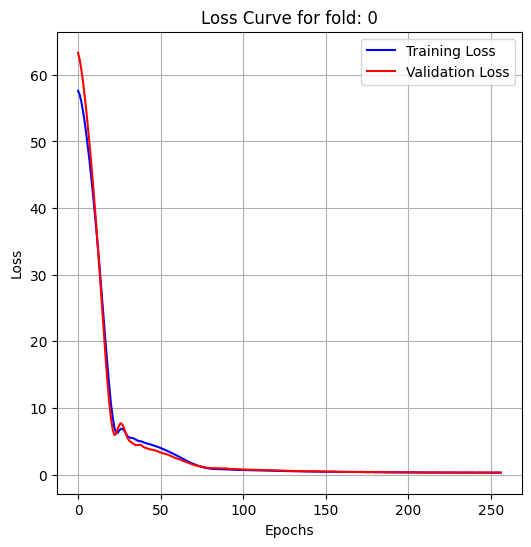

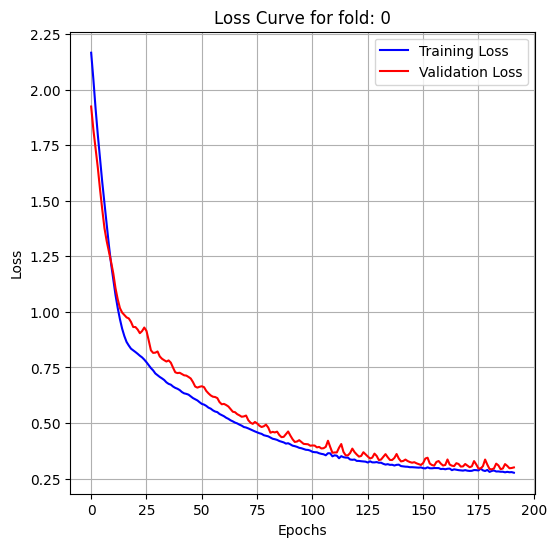

In [32]:
# changed scheduler compared to the previous cell, added nesterov
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}

# retrain the model with the best parameters
best_model = MLP()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=50)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300,
            verbose=True,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=10, cooldown=3,
                                                     verbose=True, min_lr=1e-6), skip_plot_points=65,clip=0.8)
modelv1 = best_model


In [33]:
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(best_model, test_loader))

Evaluating the model on the test set
0.6741400361061096


In [18]:
'''test_loader = DataLoader(CupDataset(blind_data))

# plot twist, it's only the inputs

# Evaluate the trained model on the test set
model = best_model
model.eval()  # Set the model to evaluation mode

outputs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        output = model(inputs)
        outputs.append(output)

outputs'''

"test_loader = DataLoader(CupDataset(blind_data))\n\n# plot twist, it's only the inputs\n\n# Evaluate the trained model on the test set\nmodel = best_model\nmodel.eval()  # Set the model to evaluation mode\n\noutputs = []\nwith torch.no_grad():\n    for inputs, labels in test_loader:\n        output = model(inputs)\n        outputs.append(output)\n\noutputs"

In [41]:
parameters = [
    {'optimizer': 'SGD', 'lr': [0.01, 0.0075, 0.005, 0.003, 0.001], 'weight_decay': [0.0, 0.001, 0.0001],
     'momentum': [0.95, 0.9, 0.85],
     'nesterov': [True, False]}
]
lr_scheduler_params = {'mode': 'min', 'factor': 0.75, 'patience': 5, 'cooldown': 3, 'min_lr': 1e-6}
# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLPv3, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False, patience=20)

Avg Train Loss: 0.6770484268665313, Avg Val Loss: 0.7488349080085754, Avg Fluctuation: 1.279628525162586
('SGD', {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.95, 'nesterov': False})
Avg Train Loss: 0.4923172861337662, Avg Val Loss: 0.5728974044322968, Avg Fluctuation: 0.46593598128946817
('SGD', {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.95, 'nesterov': True})
Avg Train Loss: 0.5942963272333145, Avg Val Loss: 0.680247676372528, Avg Fluctuation: 0.06033826513809902
('SGD', {'lr': 0.01, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True})
Avg Train Loss: 0.7483059674501419, Avg Val Loss: 0.8302245020866394, Avg Fluctuation: 0.04587269343757833
('SGD', {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.85, 'nesterov': False})
Avg Train Loss: 0.6695449993014335, Avg Val Loss: 0.7371187210083008, Avg Fluctuation: 0.04426819747859417
('SGD', {'lr': 0.0075, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True})
Avg Train Loss: 0.7171275824308395, Avg Val Loss: 0.7797642230987549,

{'lr': 0.001, 'weight_decay': 0.0001, 'momentum': 0.85, 'nesterov': False, 'optimizer': 'SGD'}
Fold: 0
Train Epoch: 0 Loss: 57.37086009979248 Val Loss: 51.442039489746094
Train Epoch: 1 Loss: 57.253756523132324 Val Loss: 51.30337142944336
Train Epoch: 2 Loss: 57.07985210418701 Val Loss: 51.13310623168945
Train Epoch: 3 Loss: 56.8777437210083 Val Loss: 50.951019287109375
Train Epoch: 4 Loss: 56.6714506149292 Val Loss: 50.758567810058594


C:\Users\alext\Desktop\Uni\ML\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 5 Loss: 56.44136619567871 Val Loss: 50.55889129638672
Train Epoch: 6 Loss: 56.2181282043457 Val Loss: 50.35306167602539
Train Epoch: 7 Loss: 55.971659660339355 Val Loss: 50.13923263549805
Train Epoch: 8 Loss: 55.714049339294434 Val Loss: 49.91574478149414
Train Epoch: 9 Loss: 55.45906352996826 Val Loss: 49.68117904663086
Train Epoch: 10 Loss: 55.20069980621338 Val Loss: 49.434974670410156
Train Epoch: 11 Loss: 54.90854454040527 Val Loss: 49.17564392089844
Train Epoch: 12 Loss: 54.61579704284668 Val Loss: 48.902740478515625
Train Epoch: 13 Loss: 54.31459140777588 Val Loss: 48.615333557128906
Train Epoch: 14 Loss: 53.9642391204834 Val Loss: 48.311607360839844
Train Epoch: 15 Loss: 53.6024808883667 Val Loss: 47.99011993408203
Train Epoch: 16 Loss: 53.22355556488037 Val Loss: 47.650291442871094
Train Epoch: 17 Loss: 52.82874393463135 Val Loss: 47.28998565673828
Train Epoch: 18 Loss: 52.419193267822266 Val Loss: 46.907997131347656
Train Epoch: 19 Loss: 51.9653902053833 Val Loss

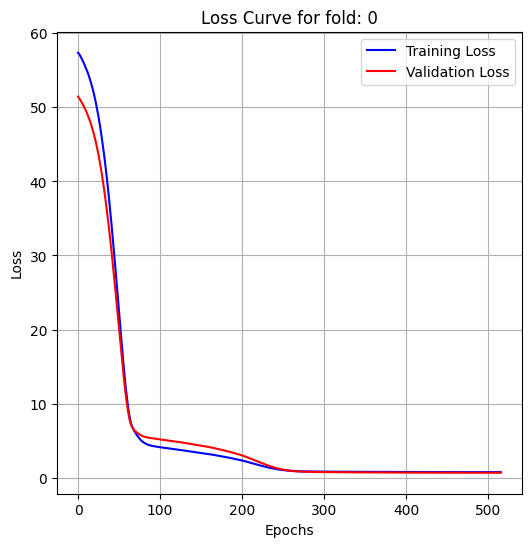

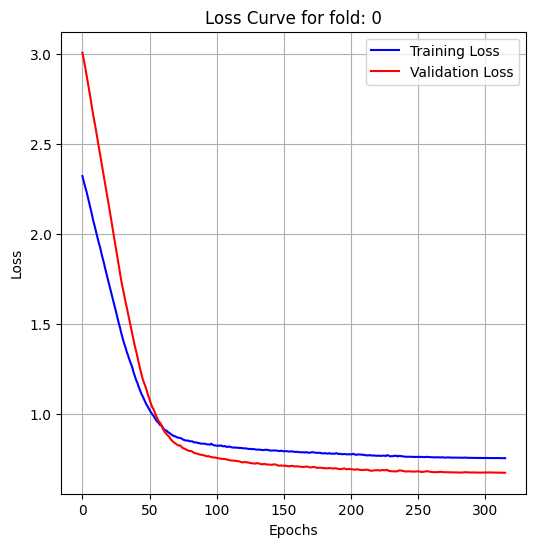

In [47]:
# retrain the model with the best parameters
#best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params)
best_model = MLPv3()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=50)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=1000,
            verbose=True,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, cooldown=3,
                                                     verbose=True, min_lr=1e-6), clip=.80, skip_plot_points=200, patience=20)

modelv3 = best_model

# End of remake --- rest to be done

In [43]:
lr_scheduler_params = {'mode': 'min', 'factor': 0.25, 'patience': 10, 'cooldown': 3, 'min_lr': 1e-8}

In [22]:

# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLPv3, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False, stability_threshold=0.5, patience=20)

Avg Train Loss: 0.5855376631021499, Avg Val Loss: 0.6485420227050781, Avg Fluctuation: 0.05101850837827019
('SGD', {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True})
Avg Train Loss: 5.14954000711441, Avg Val Loss: 5.3116155624389645, Avg Fluctuation: 0.3841994905712629
('SGD', {'lr': 0.001, 'weight_decay': 0.001, 'momentum': 0.75, 'nesterov': False})
Avg Train Loss: 0.6918656587600708, Avg Val Loss: 0.7379680156707764, Avg Fluctuation: 0.14610642251114442
('SGD', {'lr': 0.01, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': False})
Avg Train Loss: 0.7172711938619614, Avg Val Loss: 0.760023295879364, Avg Fluctuation: 0.05035881860095538
('SGD', {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': True})
Avg Train Loss: 3.642559254169464, Avg Val Loss: 3.626428556442261, Avg Fluctuation: 0.17130748942644908
('SGD', {'lr': 0.001, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': True})
Avg Train Loss: 0.6650112733244896, Avg Val Loss: 0.741725158691406

C:\Users\alext\Desktop\Uni\ML\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold: 0
Train Epoch: 0 Loss: 57.74056339263916 Val Loss: 49.54037857055664
Train Epoch: 1 Loss: 57.52619647979736 Val Loss: 49.321250915527344
Train Epoch: 2 Loss: 57.23687267303467 Val Loss: 49.07403564453125
Train Epoch: 3 Loss: 56.93461322784424 Val Loss: 48.8089599609375
Train Epoch: 4 Loss: 56.60978031158447 Val Loss: 48.5450325012207
Train Epoch: 5 Loss: 56.28628158569336 Val Loss: 48.283203125
Train Epoch: 6 Loss: 55.95669651031494 Val Loss: 48.02141189575195
Train Epoch: 7 Loss: 55.63187217712402 Val Loss: 47.73604965209961
Train Epoch: 8 Loss: 55.277716636657715 Val Loss: 47.42874526977539
Train Epoch: 9 Loss: 54.89651679992676 Val Loss: 47.09138488769531
Train Epoch: 10 Loss: 54.466278076171875 Val Loss: 46.72200393676758
Train Epoch: 11 Loss: 54.005666732788086 Val Loss: 46.297340393066406
Train Epoch: 12 Loss: 53.47153186798096 Val Loss: 45.81881332397461
Train Epoch: 13 Loss: 52.85480976104736 Val Loss: 45.274505615234375
Train Epoch: 14 Loss: 52.16084289550781 Val Loss: 4

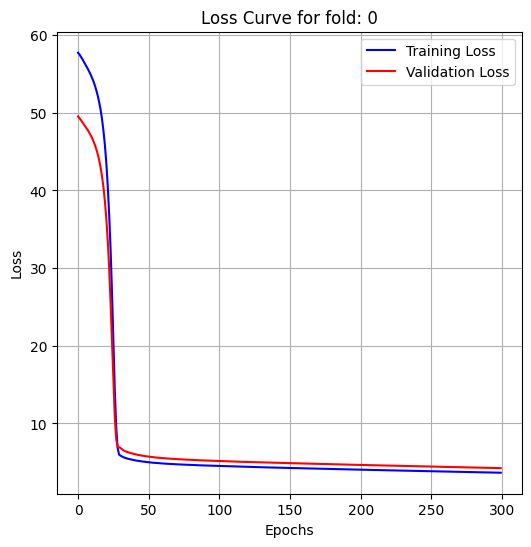

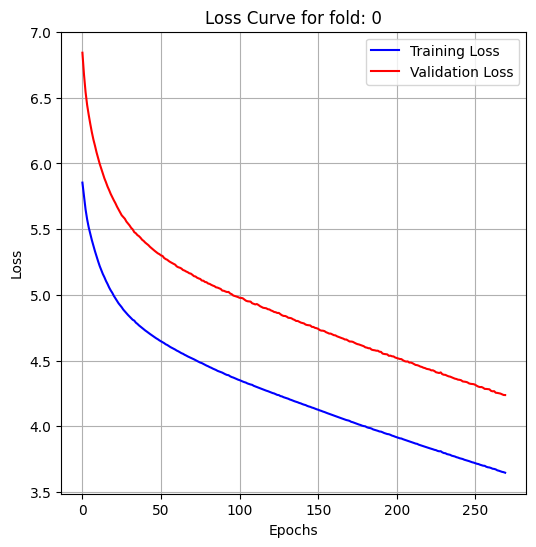

In [31]:
# retrain the model with the best parameters
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params)
best_model = MLPv3()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=50)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300,
            verbose=True,
            skip_plot_points=30,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, cooldown=3,
                                                     verbose=True, min_lr=1e-6), clip=None)

modelv3 = best_model

In [24]:
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(best_model, test_loader))

Evaluating the model on the test set
2.4702699184417725


In [25]:
def torch_pred(model, test_loader: DataLoader):
    # evaluate the model on the test set using mee metric
    predictions = []
    true = []
    with torch.no_grad():
        for data, true in test_loader:
            output = model(data)
            predictions.append(output)
    return predictions, true


In [26]:
# predict for model 1 and 3
predictions1, true = torch_pred(modelv1, val_loader)
predictions3, _ = torch_pred(modelv3, val_loader)

In [27]:
# check type of predictions

In [28]:
# find the a,b parameters that give the best result of a * model1 + b * model3
def find_best_a_b(predictions1, predictions3, y_dev):
    best_a = 0
    best_b = 0
    best_mee = 100

    for a in np.linspace(0, 1, 100):
        for b in np.linspace(0, 1, 100):
            if a + b == 1:
                pred = a * predictions1.cpu() + b * predictions3.cpu()
                mee = torch.norm(pred - y_dev, dim=-1).mean().item()
                print(mee)
                if mee < best_mee:
                    best_mee = mee
                    best_a = a
                    best_b = b
    return best_a, best_b, best_mee


alfa, beta, _ = find_best_a_b(torch.stack(predictions1), torch.stack(predictions3), true.cpu())
print(alfa, beta)

2.7837045192718506
2.7859160900115967
2.7917556762695312
2.801271915435791
2.814497947692871
2.8520901203155518
2.87638521194458
2.904238700866699
2.935520648956299
3.007668972015381
3.048112154006958
3.0911567211151123
3.1365628242492676
3.184096336364746
3.2335364818573
3.337332248687744
3.3913331031799316
3.4465301036834717
3.502791166305542
3.5599987506866455
3.6180508136749268
3.6768569946289062
3.7363386154174805
3.796424150466919
3.857053756713867
3.9181747436523438
3.979738712310791
4.041704177856445
4.104034900665283
4.166697025299072
4.229663848876953
4.292909145355225
4.356410503387451
4.420146942138672
4.48410177230835
4.548257827758789
4.612601280212402
4.677119731903076
4.741801738739014
4.806635856628418
4.871614456176758
4.936728477478027
5.001971244812012
5.067335605621338
5.132817268371582
5.198408126831055
5.264106273651123
5.329906463623047
5.3958048820495605
5.461798667907715
5.527884483337402
5.594058990478516
5.660318374633789
5.726662635803223
5.793085098266602


In [29]:
# predict for model 1 and 3
predictions1, true = torch_pred(modelv1, test_loader)
predictions3, _ = torch_pred(modelv3, test_loader)
#alfa = 0.8787878787878789
#beta = 0.12121212121212122

combined_predictions = alfa * torch.stack(predictions1) + beta * torch.stack(predictions3)

In [30]:
print('Original')
print(torch.norm(torch.stack(predictions1) - true, dim=-1).mean().item())
print(torch.norm(torch.stack(predictions3) - true, dim=-1).mean().item())

print('Linear Combination')
print(torch.norm(combined_predictions - true, dim=-1).mean().item())

Original
8.751813888549805
2.4702699184417725
Linear Combination
2.4702699184417725
